![Imagen de WhatsApp 2024-12-10 a las 14.07.47_705c4300.jpg](<attachment:Imagen de WhatsApp 2024-12-10 a las 14.07.47_705c4300.jpg>)
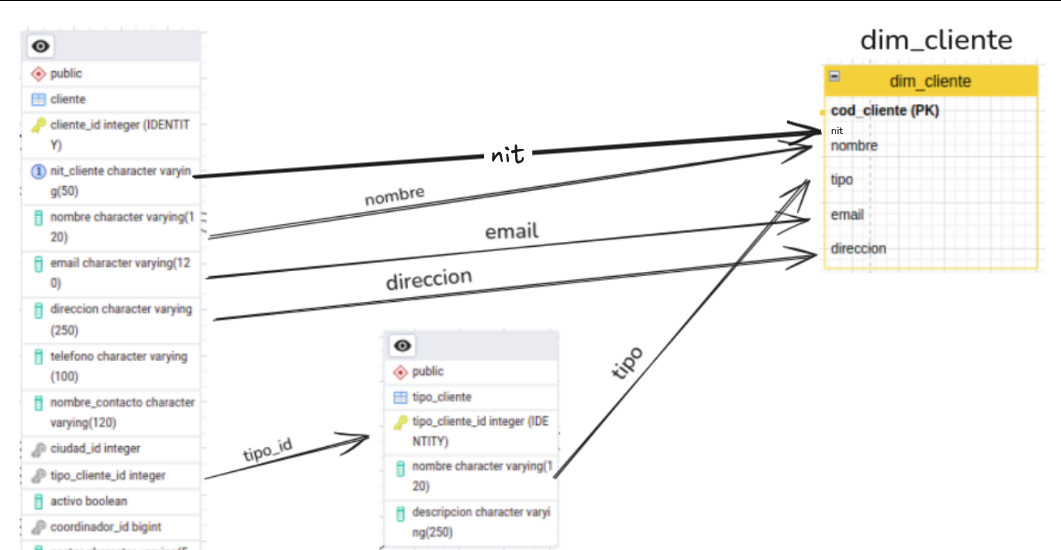

## Importar librerías

In [ ]:
# Importar las librerias
from datetime import datetime  # Para obtener el tiempo actual
import pandas as pd  # Para manipular datos
import sqlalchemy as sa  # Para conectar a la base de datos
import utils.conn_tools as ct  # Para leer la configuración de conexión
import numpy as np  # Para tener el Nan de Python

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extracción

In [ ]:
# Leer los datos de las tablas
cliente_df = pd.read_sql_table('cliente', con=engine_src)
tipo_cliente_df = pd.read_sql_table('tipo_cliente', con=engine_src)

## Transformar

Combinamos los datos de cliente y tipo de cliente

In [ ]:
cliente_tipo_merged = cliente_df.merge(
    tipo_cliente_df[["tipo_cliente_id", "nombre"]],
    left_on="tipo_cliente_id",
    right_on="tipo_cliente_id",
    how="left",
)

# Se muestran las primeras dos filas
# nombre_x corresponde al nombre del cliente, nombre_y al nombre del tipo de cliente
cliente_tipo_merged.head(2)

Extraemos los campos relevantes y renombramos las columnas

In [ ]:
# Creamos el dataFrame renombrando las columnas
dim_cliente = pd.DataFrame(
    {
        "nit": cliente_tipo_merged["nit_cliente"],
        "name": cliente_tipo_merged["nombre_x"],
        "type": cliente_tipo_merged["nombre_y"],
        "email": cliente_tipo_merged["email"],
        "address": cliente_tipo_merged["direccion"],
    }
)
dim_cliente.head()

In [ ]:
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_cliente_table = sa.Table(
    "dim_cliente",
    metadata,
    # Primary key
    sa.Column("key_cliente", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension keys
    sa.Column("nit", sa.String, nullable=False),
    sa.Column("name", sa.String, nullable=False),
    sa.Column("type", sa.String, nullable=False),
    sa.Column("email", sa.String, nullable=False),
    sa.Column("address", sa.String, nullable=False),
)

metadata.create_all(engine_etl)

## Cargar datos al ETL

In [ ]:
dim_cliente.to_sql(
    name="dim_cliente",
    con=engine_etl,
    if_exists="append",  # Create table if not exists, else append
    index=False,  # Do not create index because we already have one PK
)